# MedCLIP-SAMv2
Welcome to demo of MedCLIP-SAMv2. From here, you can use MedCLIP-SAMv2 to generate a pseudo-mask of any image you like using our zero-shot method.

# How to run?


1.   Setup the environment with all dependencies and libraries
3.   Put your image (file path from colab) in 'image_path'.
4.   Type text in 'text'.
5.   Hit play button to generate a saliency
6.   Run the Postprocessing cell block after that
7.   Run the SAM Cell block to get the final segmentation output


Special thanks to [open_clip](https://github.com/mlfoundations/open_clip), [M2IB](https://github.com/YingWANGG/M2IB), and [segment-anything](https://github.com/facebookresearch/segment-anything) for making their valuable code publicly available.







In [1]:
%pwd
%cd ./saliency_maps


c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2\saliency_maps


In [2]:
#@title Enviroment setup

# get repo and install env
# !git clone https://github.com/HealthX-Lab/MedCLIP-SAMv2
# !pip install -r colab_requirements.txt

import torch
import torchvision
%cd ..
%cd segment-anything
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth



c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2
c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2\segment-anything
PyTorch version: 2.6.0+cu118
Torchvision version: 0.21.0+cu118
CUDA is available: True


ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/segment-anything.git'": Expected package name at the start of dependency specifier
    'git+https://github.com/facebookresearch/segment-anything.git'
    ^


In [3]:
%cd ..
%cd saliency_maps

c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2
c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2\saliency_maps


In [21]:
import warnings

warnings.filterwarnings("ignore")
import os
import torch
import clip
import cv2
import sys
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

from transformers import CLIPProcessor
from scripts.plot import generate_shades_with_alpha, plot_text_with_colors, visualize_vandt_heatmap
from scripts.methods import vision_heatmap_iba, text_heatmap_iba
from transformers import AutoModel, AutoProcessor, AutoTokenizer
from PIL import Image, ImageOps

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def plot(model, image, text, vbeta=0.1, vvar=1, vlayer=9, tbeta=0.1, tvar=1, tlayer=9):
    # Preprocess image
    image = Image.open(image).convert("RGB")
    image_feat = processor(images=image, return_tensors="pt")["pixel_values"].to(device)  # 3*224*224
    # Tokenize text
    text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)]).to(device)
    text_words = tokenizer.convert_ids_to_tokens(text_ids[0].tolist())
    # Train information bottleneck on image
    print("Training M2IB on the image...")
    vmap = vision_heatmap_iba(text_ids, image_feat, model, vlayer, vbeta, vvar)
    # Train information bottleneck on text
    print("Training M2IB on the text...")
    tmap = text_heatmap_iba(text_ids, image_feat, model, tlayer, tbeta, tvar)
    # Just for demonstration purposes
    image_under = processor2(images=image, return_tensors="pt", do_normalize=False)["pixel_values"][0].permute(1, 2, 0)
    visualize_vandt_heatmap(tmap, vmap, text_words, image_under)
    img = np.array(image)
    vmap = cv2.resize(np.array(vmap), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST) * 255
    return vmap

In [22]:
%cd saliency_maps/

c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2\saliency_maps


In [23]:
# model = AutoModel.from_pretrained("chuhac/BiomedCLIP-vit-bert-hf", trust_remote_code=True).to(device)
model = AutoModel.from_pretrained(r"./model/", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("chuhac/BiomedCLIP-vit-bert-hf", trust_remote_code=True)
processor2 = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("chuhac/BiomedCLIP-vit-bert-hf", trust_remote_code=True)

In [24]:
%cd ..

c:\Users\Alireza Vaezi\Desktop\MedCLIP-SAMv2


Training M2IB on the image...


Training Bottleneck: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Training M2IB on the text...


Training Bottleneck: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


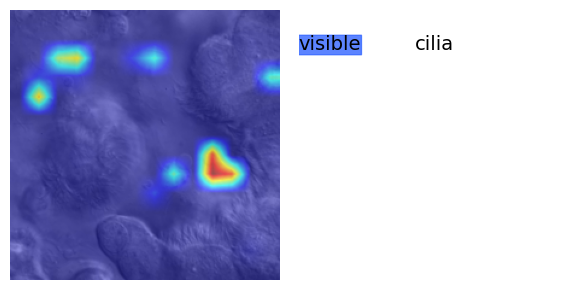

In [29]:
# @title ## Saliency Maps
image_path = "./saliency_maps/cilia_dataset_split/train_images/1001-5.png"  # @param {type:"string"}
text = "visible cilia"  # @param {type:"string"}
vmap = plot(model, image_path, text)

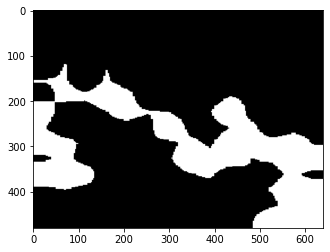

In [13]:
# @title ## Postprocessing

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=12)
attn_weights = vmap / 255
# Keep only high attention weight scores
h, w = attn_weights.shape
filtered_attn_weights = attn_weights > 0.1
attn_weights = attn_weights * filtered_attn_weights
image = cv2.resize(attn_weights, (256, 256), interpolation=cv2.INTER_NEAREST)
flat_image = image.reshape(-1, 1)

labels = kmeans.fit_predict(flat_image)

segmented_image = labels.reshape(256, 256)

centroids = kmeans.cluster_centers_.flatten()

# Identify the background cluster (assuming it has the lowest centroid value)
background_cluster = np.argmin(centroids)

# Mark background pixels as 0 and foreground pixels as 1
segmented_image = np.where(segmented_image == background_cluster, 0, 1)

segmented_image = cv2.resize(segmented_image, (w, h), interpolation=cv2.INTER_NEAREST)
segmented_image = segmented_image.astype(np.uint8) * 255

nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(segmented_image)
sizes = stats[:, cv2.CC_STAT_AREA]

# Sort sizes (ignoring the background at index 0)
sorted_sizes = sorted(sizes[1:], reverse=True)

# Change this here if you want to segment more than one contour
num_contours = 1

# Determine the top K sizes
top_k_sizes = sorted_sizes[:num_contours]

im_result = np.zeros_like(im_with_separated_blobs)

for index_blob in range(1, nb_blobs):
    if sizes[index_blob] in top_k_sizes:
        im_result[im_with_separated_blobs == index_blob] = 255

segmented_image = im_result

cv2.imwrite("./saliency_out.png", segmented_image)

plt.imshow(segmented_image, cmap="gray")

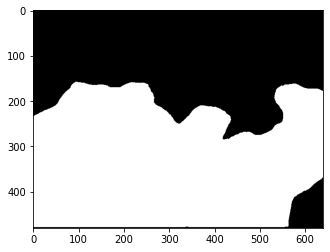

In [14]:
# @title Step 3: SAM Output

import sys

sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

_CONTOUR_INDEX = 1 if cv2.__version__.split(".")[0] == "3" else 0


def scoremap2bbox(scoremap, multi_contour_eval=False):
    height, width = scoremap.shape
    scoremap_image = (scoremap * 255).astype(np.uint8)
    contours, _ = cv2.findContours(image=scoremap_image, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    num_contours = len(contours)

    if len(contours) == 0:
        return np.asarray([[0, 0, width, height]]), 1

    if not multi_contour_eval:
        # contours = [max(contours, key=cv2.contourArea)]
        contours = [np.concatenate(contours)]

    estimated_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x0, y0, x1, y1 = x, y, x + w, y + h
        x1 = min(x1, width - 1)
        y1 = min(y1, height - 1)
        estimated_boxes.append([x0, y0, x1, y1])

    return estimated_boxes, contours, num_contours


sam_checkpoint = "segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

prompts = "boxes"  # @param ["boxes", "points","both"]
pos_num_points = 2  # @param {type:"integer"}
neg_num_points = 2  # @param {type:"integer"}

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
img = cv2.imread(image_path)
mask = cv2.imread(f"saliency_out.png", cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
predictor.set_image(img)

# Change Multicontour to True if you have more than one contour to segment
bounding_boxes, contours, num_contours = scoremap2bbox(mask, multi_contour_eval=False)

if prompts == "boxes":
    bounding_boxes = np.array(bounding_boxes)
    input_boxes = torch.tensor(bounding_boxes, device=device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, img.shape[:2])
    masks, scores, _ = predictor.predict_torch(point_coords=None, point_labels=None, boxes=transformed_boxes, multimask_output=False)
    masks = masks.cpu().numpy()
elif prompts == "points":
    pos_random_points = []
    neg_random_points = []
    candidate_points = np.argwhere(mask.transpose(1, 0) > 0)
    h, w = mask.shape
    random_index = np.random.choice(len(candidate_points), pos_num_points, replace=False)
    pos_random_points = candidate_points[random_index]

    candidate_points = np.argwhere(mask.transpose(1, 0) == 0)
    random_index = np.random.choice(len(candidate_points), neg_num_points, replace=False)
    neg_random_points = candidate_points[random_index]
    all_random_points = np.concatenate([pos_random_points, neg_random_points])
    all_input_labels = [1] * len(pos_random_points) + [0] * len(neg_random_points)
    masks, scores, _ = predictor.predict(point_coords=all_random_points, point_labels=all_input_labels, multimask_output=False)
else:
    input_boxes = torch.tensor(bounding_boxes, device=device)
    pos_random_points = []
    neg_random_points = []
    candidate_points = np.argwhere(mask.transpose(1, 0) > 0)
    h, w = mask.shape
    random_index = np.random.choice(len(candidate_points), pos_num_points, replace=False)
    pos_random_points = candidate_points[random_index]
    candidate_points = np.argwhere(mask.transpose(1, 0) == 0)
    random_index = np.random.choice(len(candidate_points), neg_num_points, replace=False)
    neg_random_points = candidate_points[random_index]
    all_random_points = np.concatenate([pos_random_points, neg_random_points])
    all_input_labels = [1] * len(pos_random_points) + [0] * len(neg_random_points)
    input_points = torch.tensor(all_random_points, device=device)
    input_labels = torch.tensor(all_input_labels, device=device)
    input_points = input_points.repeat((len(bounding_boxes), 1, 1))
    input_labels = input_labels.repeat((len(bounding_boxes), 1))
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
    masks, scores, _ = predictor.predict_torch(point_coords=transformed_points, point_labels=input_labels, boxes=transformed_boxes, multimask_output=False)
    masks = masks.cpu().numpy()

output = "./sam_output.png"
mask_sam = np.squeeze(masks * 255).astype("uint8")
cv2.imwrite(output, mask_sam)
plt.imshow(mask_sam, cmap="gray")